# 4. Test predictions results visualization

## Setup

In [2]:
import os

import abnumber
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import bin.feature_generators as fg
import bin.params as p
import bin.utils as u

In [3]:
sns.set_theme()
sns.set(rc={'figure.figsize':(15, 4)})

In [4]:
CLUSTERING_CHAINS = p.CLUSTERING_CHAINS
CHAINS = p.CHAINS

In [5]:
EXPERIMENT_SETTINGS = f'{CLUSTERING_CHAINS}_{CHAINS}'
EXP_STRING = f'(scheme={p.FINAL_NUMBERING_SCHEME}, clustering={CLUSTERING_CHAINS}, chains={CHAINS}, dataset=TEST)'
LOW = 10
HIGH = 50

**Create a directory to store result plots in:**

In [6]:
TEST_PNG_DIR_PATH = f'{p.DATA_DIR}/png/test/'
command = f'mkdir -p {TEST_PNG_DIR_PATH}'
! $command

**Load the predictions for individual scenarios and merge them into one big dataframe:**

In [7]:
PREDICTIONS_DIR_PATH = f'{p.DATA_DIR}/csv/test/predictions/'

In [8]:
result_filenames = [fn for fn in os.listdir(PREDICTIONS_DIR_PATH) if EXPERIMENT_SETTINGS in fn]
scenario_dfs = []
for result_filename in result_filenames:
    scenario_df = pd.read_csv(f'{PREDICTIONS_DIR_PATH}/{result_filename}', index_col=0)
    scenario_df.insert(0, 'scenario', result_filename[:-4]) # last 4 chars are .csv extension
    scenario_dfs.append(scenario_df)
    
# add 'random' model
random_df = scenario_dfs[2].copy()
random_df['prediction'] = np.random.uniform(0, 100, len(random_df))
random_df['scenario'] = f'lco_whole_sequence_all_H_RANDOM'
scenario_dfs.append(random_df)

predictions_df = pd.concat(scenario_dfs).reset_index(drop=True)
predictions_df.tail(n=3)

,scenario,sequence_id,position,prediction
1159969,lco_whole_sequence_all_H_RANDOM,7X9E:H,149,62.105224
1159970,lco_whole_sequence_all_H_RANDOM,7Z0X:H,149,21.167642
1159971,lco_whole_sequence_all_H_RANDOM,7Z0Y:H,149,29.787482


**Load the SASA dataframe in the same format so it is easy to compute differences between predictions and the actual values:**

In [9]:
seqs = predictions_df['sequence_id'].unique()
X, Y = u.load_dataset('test', chains=CHAINS)
Y.index = Y['Id']; Y.drop(columns='Id', inplace=True)
sasa_df = u.positionize_sasa_df(Y.loc[seqs, :], pd.Series(Y.index)).rename(columns={'prediction': 'sasa'})
sasa_df = pd.concat([sasa_df] * predictions_df['scenario'].nunique()).reset_index(drop=True)
sasa_df.tail(n=3)

,sequence_id,position,sasa
1159969,7X9E:H,149,58.8
1159970,7Z0X:H,149,73.3
1159971,7Z0Y:H,149,71.5


**Create final results dataframe, that will contain actual sasa values, predictions, errors and absolute errors:**

In [10]:
results_df = predictions_df.copy()
results_df.insert(3, 'sasa', sasa_df['sasa'])
results_df.insert(5, 'error', results_df['prediction']-results_df['sasa'])
results_df.insert(6, 'abs_error', np.abs(results_df['error']))
results_df.to_csv(f'{p.DATA_DIR}/csv/test/results_{EXPERIMENT_SETTINGS}.csv')
results_df.head(n=7)

,scenario,sequence_id,position,sasa,prediction,error,abs_error
0,lco_whole_sequence_all_H_BLknnwholeseqn3,6LCS:H,1,NaN,31.700000,NaN,NaN
1,lco_whole_sequence_all_H_BLknnwholeseqn3,6LDV:H,1,NaN,NaN,NaN,NaN
2,lco_whole_sequence_all_H_BLknnwholeseqn3,6LDW:H,1,NaN,NaN,NaN,NaN
3,lco_whole_sequence_all_H_BLknnwholeseqn3,6LDX:H,1,100.0,NaN,NaN,NaN
4,lco_whole_sequence_all_H_BLknnwholeseqn3,6LDY:H,1,NaN,NaN,NaN,NaN
5,lco_whole_sequence_all_H_BLknnwholeseqn3,6LRA:H,1,80.2,65.533333,-14.666667,14.666667
6,lco_whole_sequence_all_H_BLknnwholeseqn3,6LTG:H,1,58.7,93.766667,35.066667,35.066667


In [11]:
results_df['scenario'].unique()

array(['lco_whole_sequence_all_H_BLknnwholeseqn3',
       'lco_whole_sequence_all_H_BLavgpos',
       'lco_cont_window_r1_all_H_randomForestN30',
       'lco_cont_window_r2_all_H_randomForestN30',
       'lco_cont_window_r3_all_H_randomForestN30',
       'lco_cont_window_r3_all_H_randomForestN5',
       'lco_whole_sequence_all_H_BLmeansamerespos',
       'lco_whole_sequence_all_H_BLmediansamerespos',
       'lco_whole_sequence_all_H_BLknnwholeseqn10',
       'lco_cont_window_r4_all_H_randomForestN30',
       'lco_whole_sequence_all_H_RANDOM'], dtype=object)

**Utility functions:**

In [12]:
def extract_from_scenario(s):
    # features
    m = 'F: '
    tokens = s.split('_')
    if 'whole' in s: m += 'whole sequence\n'
    elif 'window' in s: m += f'sliding window (radius={tokens[3][1:]})\n'
    # model
    m += 'M: ' + tokens[-1] + '\n'
    return m

In [13]:
def get_df(data): 
    data['buried'] = data['sasa'] <= LOW
    data['exposed'] = data['sasa'] >= HIGH
    data['overpred'] = (data['buried'] == True) & (data['prediction'] >= HIGH)
    data['underpred'] = (data['exposed'] == True) & (data['prediction'] <= LOW)
    return pd.concat([        
        data.groupby('scenario')['underpred'].sum().to_frame(),
        data.groupby('scenario')['overpred'].sum().to_frame(),
    ], axis=1)

---

## Mean loss per scenario

In [14]:
scenario_means = results_df.groupby('scenario')['abs_error'].mean().to_frame().reset_index().sort_values(by='abs_error')
scenario_means.insert(0, 'model', scenario_means['scenario'].map(lambda s: s.split('_')[-1]))
scenario_means.insert(1, 'features', scenario_means['scenario'].map(lambda s: '_'.join(s.split('_')[:-1])))
scenario_means.drop(columns='scenario', inplace=True)
scenario_means = scenario_means.rename(columns={'abs_error': 'mean absolute error'})
scenario_means.index = range(1, len(scenario_means)+1)
scenario_means

,model,features,mean absolute error
1,randomForestN30,lco_cont_window_r4_all_H,5.645179
2,randomForestN30,lco_cont_window_r3_all_H,5.650591
3,randomForestN30,lco_cont_window_r2_all_H,5.738114
4,randomForestN5,lco_cont_window_r3_all_H,5.772986
5,randomForestN30,lco_cont_window_r1_all_H,5.909815
6,BLknnwholeseqn10,lco_whole_sequence_all_H,5.952079
7,BLknnwholeseqn3,lco_whole_sequence_all_H,6.024226
8,BLmediansamerespos,lco_whole_sequence_all_H,6.105357
9,BLmeansamerespos,lco_whole_sequence_all_H,6.312274
10,BLavgpos,lco_whole_sequence_all_H,7.874415


In [15]:
# machine-learning
scenario_means.loc[1:5]['mean absolute error'].mean()

5.743337050226119

In [16]:
# baseline
scenario_means.loc[6:10]['mean absolute error'].mean()

6.453669956405861

In [17]:
# random 
scenario_means.loc[11]['mean absolute error'].mean()

35.95759861703991

---

## Mean-loss-per-sample distributions by scenario

In [18]:
loss_per_sample_df = results_df.groupby(['scenario', 'sequence_id'])['abs_error'].mean().to_frame().reset_index()
    
data = loss_per_sample_df.copy()
data['scenario'] = data['scenario'].apply(extract_from_scenario)

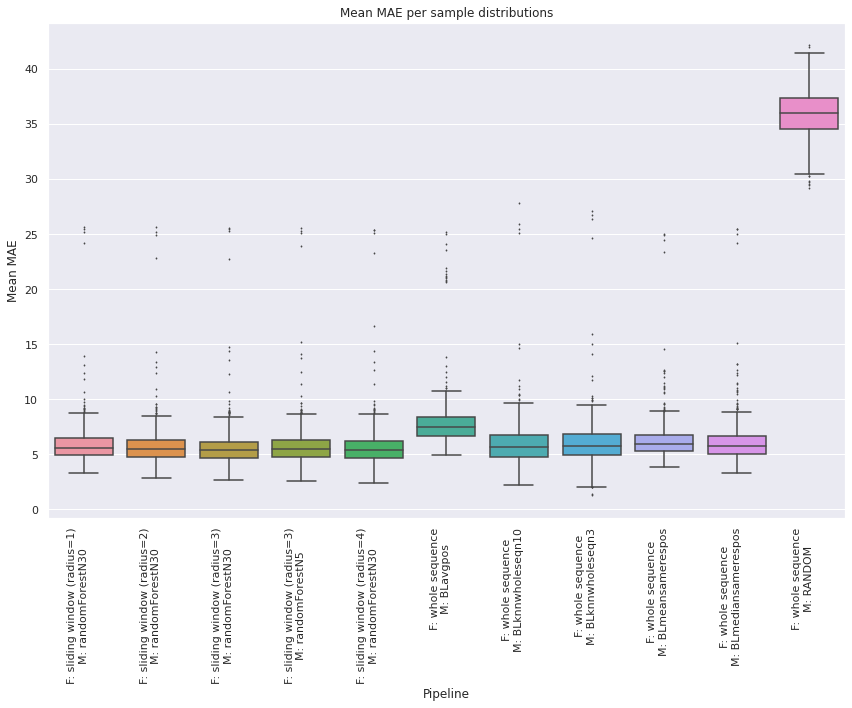

In [19]:
sns.set(rc={'figure.figsize':(12, 10)})
plot = sns.boxplot(data=data, 
                   x='scenario', 
                   y='abs_error',
                   flierprops = dict(markerfacecolor = '0.50', markersize = 1))
_ = u.annotate_plot(plot, x_rotation=90,
                title='Mean MAE per sample distributions',
                xlabel='Pipeline',
                ylabel='Mean MAE')
plot.figure.tight_layout()
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/loss_sample_scenario_boxplot_{EXPERIMENT_SETTINGS}.png')

---

## Scores per position vs. SASA distributions

**Generate the dataframe for mean absolute errors in scenario X position combinations:**

In [20]:
loss_per_position_df = results_df.groupby(['scenario', 'position'])['abs_error'].mean().to_frame().reset_index()
loss_per_position_df.head(n=5)

,scenario,position,abs_error
0,lco_cont_window_r1_all_H_randomForestN30,1,7.484705
1,lco_cont_window_r1_all_H_randomForestN30,10,11.734049
2,lco_cont_window_r1_all_H_randomForestN30,100,2.478334
3,lco_cont_window_r1_all_H_randomForestN30,101,4.281092
4,lco_cont_window_r1_all_H_randomForestN30,102,1.809139


In [55]:
l = loss_per_position_df
start, end = list(Y.columns).index('107'), list(Y.columns).index('138'); cols = list(Y.columns)[start:end]
lcdr3 = l[ (l['position'].isin(cols))].copy()
c = 'CDR3 mean absolute error'
A = lcdr3.groupby('scenario')[c].mean().to_frame(name=c).sort_values(by=c)
A.insert(0, 'model', A['scenario'].map(lambda s: s.split('_')[-1]))
A.insert(1, 'features', A['scenario'].map(lambda s: '_'.join(s.split('_')[:-1])))
A = A.drop(columns='scenario').reset_index()
A

,scenario,position,abs_error
9,lco_cont_window_r1_all_H_randomForestN30,107,0.729359
10,lco_cont_window_r1_all_H_randomForestN30,108,3.517390
11,lco_cont_window_r1_all_H_randomForestN30,109,7.609675
13,lco_cont_window_r1_all_H_randomForestN30,110,12.682027
14,lco_cont_window_r1_all_H_randomForestN30,111,19.976661
...,...,...,...
1682,lco_whole_sequence_all_H_RANDOM,133,35.474256
1683,lco_whole_sequence_all_H_RANDOM,134,36.147050
1684,lco_whole_sequence_all_H_RANDOM,135,42.907194
1685,lco_whole_sequence_all_H_RANDOM,136,46.504866


In [22]:
loss_per_position_df['abs_error'].mean()

10.758839034857456

**Let us check how many sequences has some SASA set at any given position, so we can sanity-check manually by comparing with sasa-distributions generated below (plots in the right column):**

In [23]:
print(dict(sasa_df.groupby('position')['sasa'].count()))

{'1': 5401, '10': 7062, '100': 7073, '101': 7073, '102': 7073, '103': 7073, '104': 7073, '105': 7073, '106': 7073, '107': 7073, '108': 7073, '109': 7073, '11': 7051, '110': 6985, '111': 6897, '112': 6512, '113': 5324, '114': 3839, '115': 2332, '116': 1441, '117': 891, '118': 385, '119': 77, '12': 7051, '120': 33, '121': 0, '122': 0, '123': 0, '123A': 0, '123B': 0, '123C': 0, '123D': 0, '124': 0, '125': 0, '126': 0, '127': 77, '128': 132, '129': 550, '13': 7073, '130': 1166, '131': 1859, '132': 2992, '133': 4488, '134': 6226, '135': 6776, '136': 6952, '137': 7073, '138': 7073, '139': 7073, '14': 7073, '140': 7073, '141': 7073, '142': 7073, '143': 7073, '143A': 11, '144': 7073, '145': 7073, '146': 7051, '147': 7040, '148': 6853, '149': 6666, '15': 7073, '16': 6963, '17': 7062, '18': 7051, '19': 7062, '2': 6743, '20': 7073, '21': 7073, '22': 7073, '23': 7073, '24': 7073, '25': 7073, '26': 7073, '27': 6908, '28': 0, '29': 7062, '3': 7018, '30': 7073, '31': 7073, '32': 7029, '33': 7018, '34

**Generate plots and save to the PNG files:**

  0%|          | 0/11 [00:00<?, ?it/s]

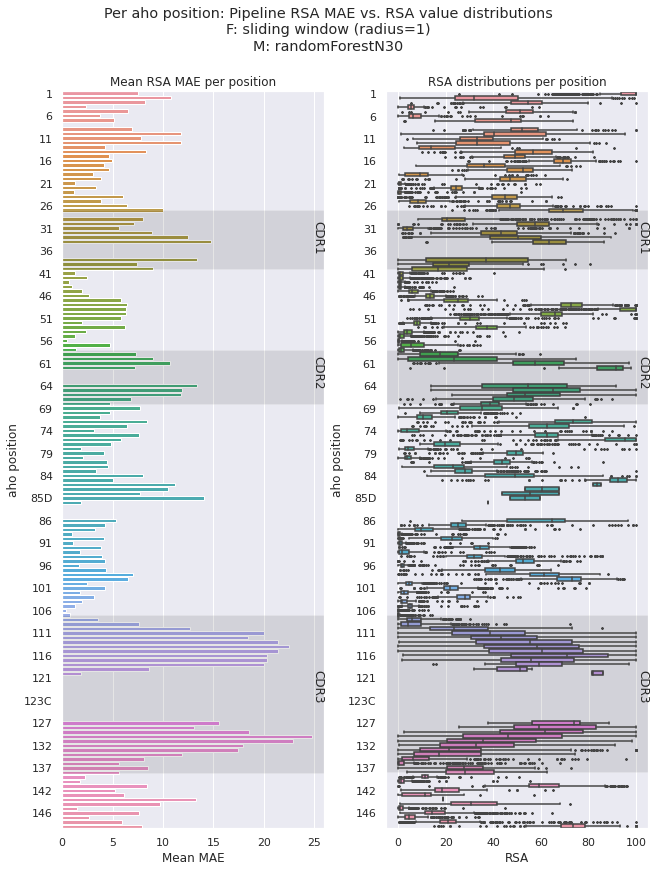

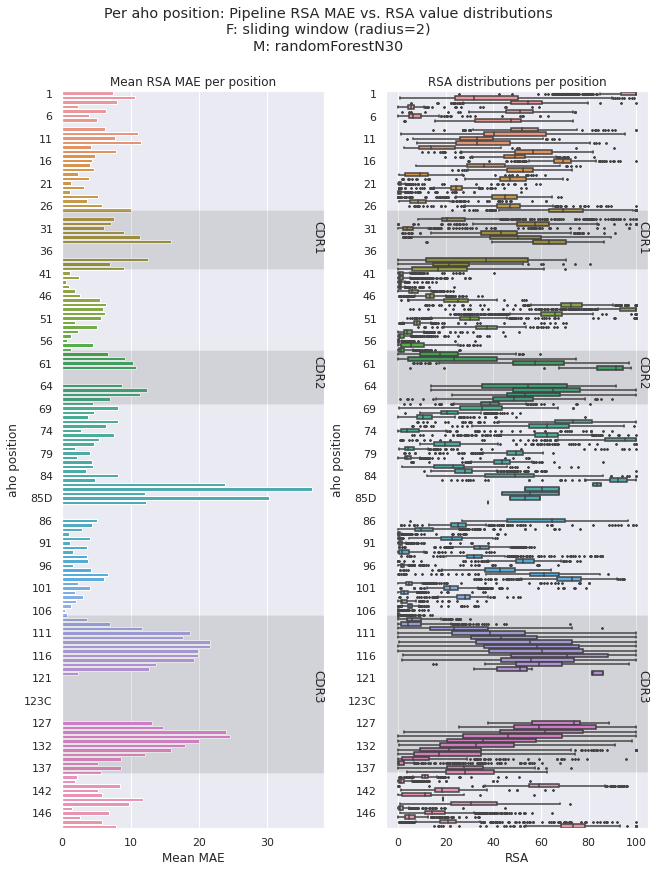

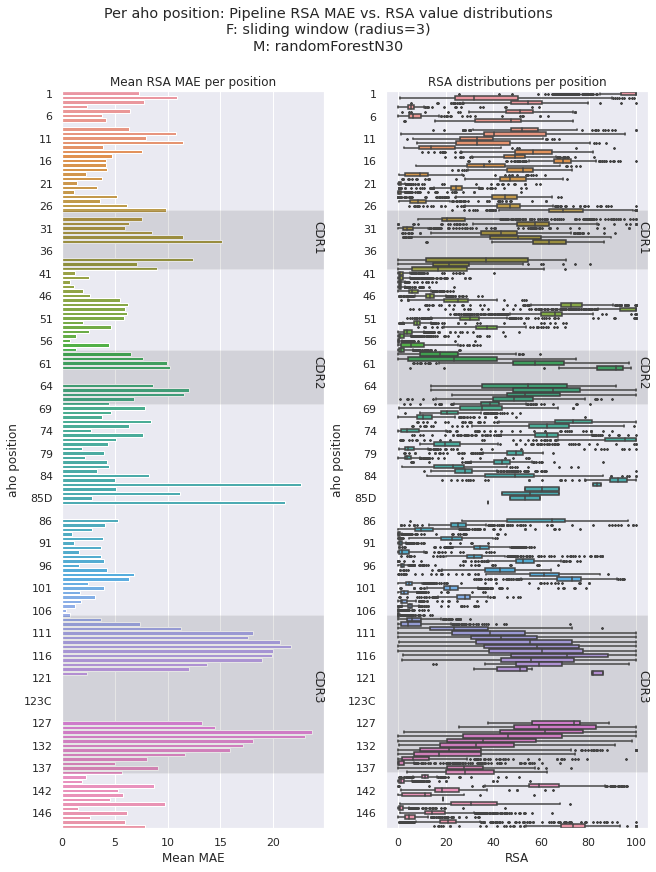

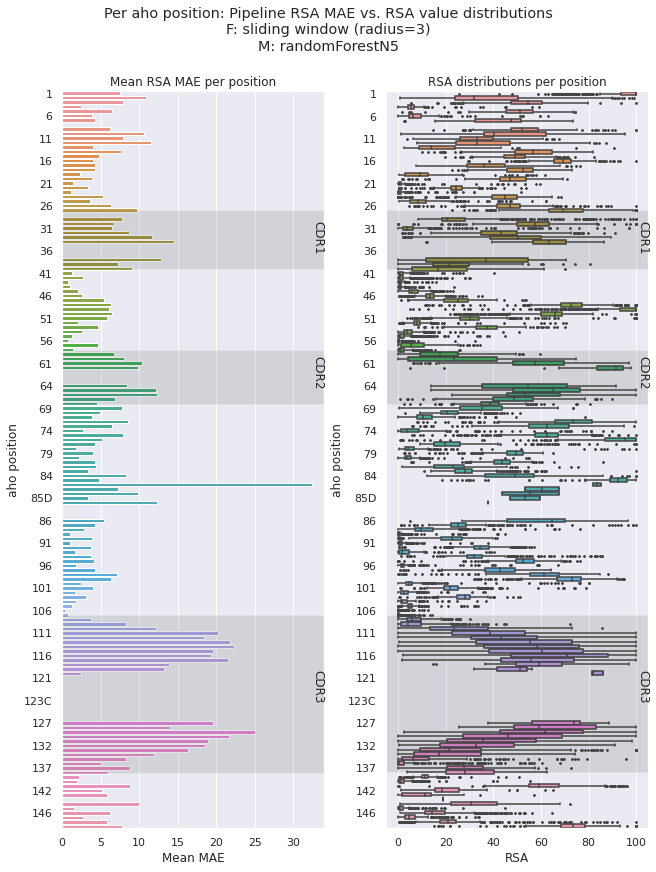

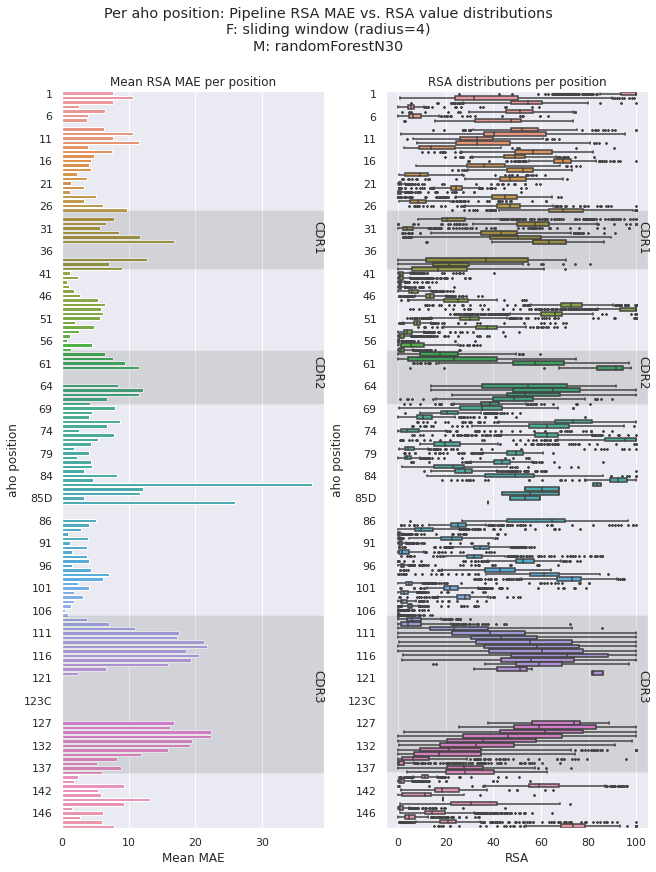

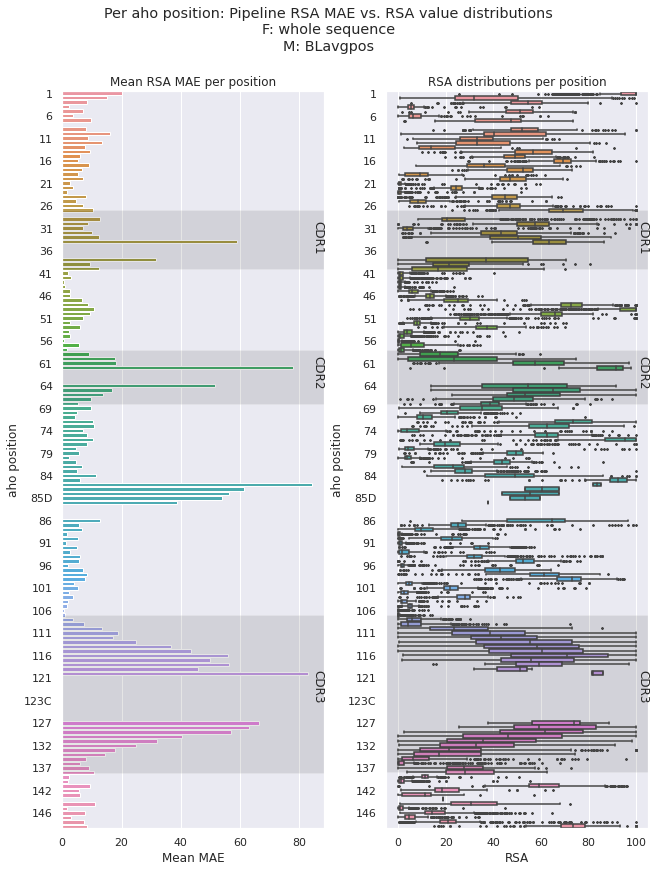

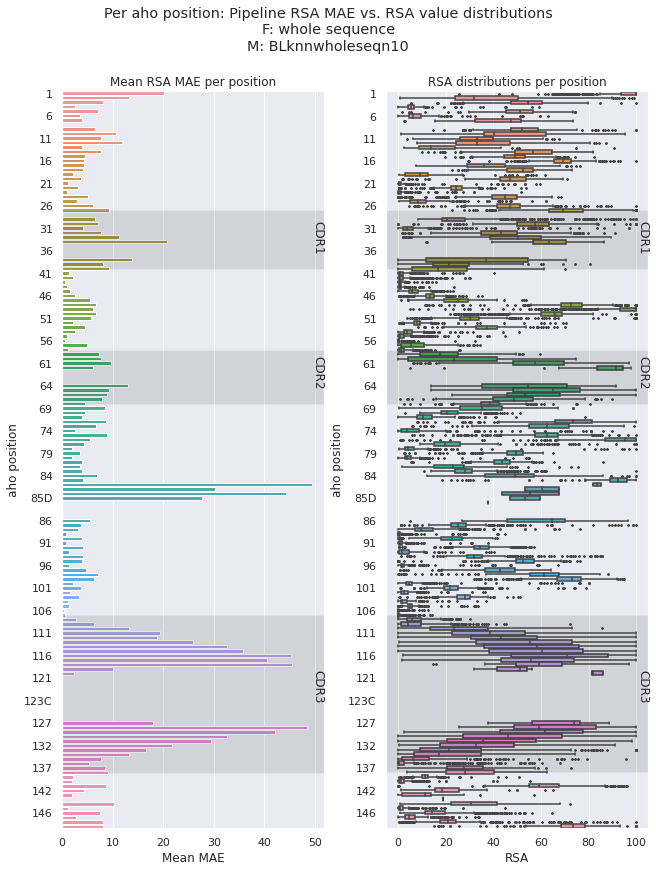

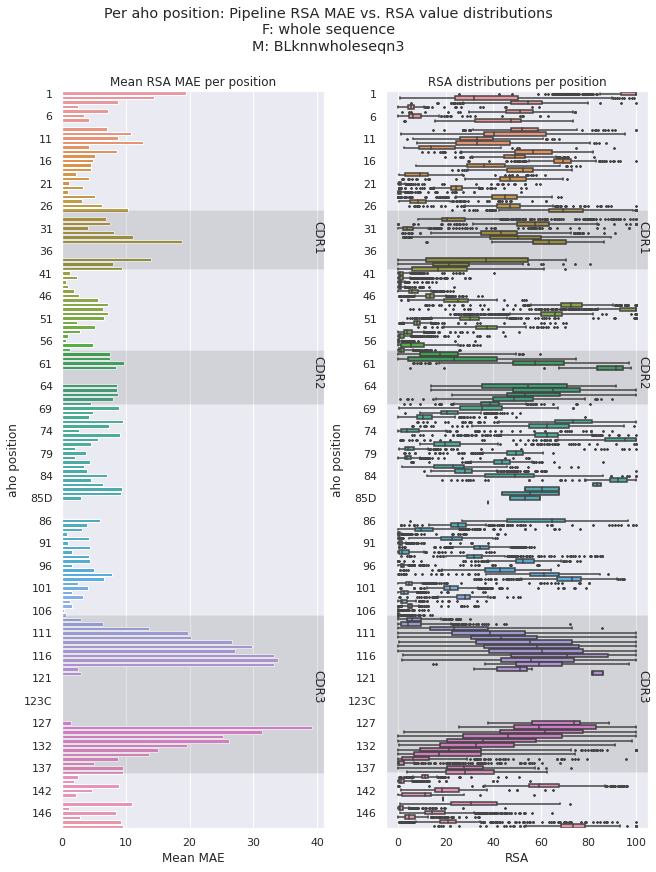

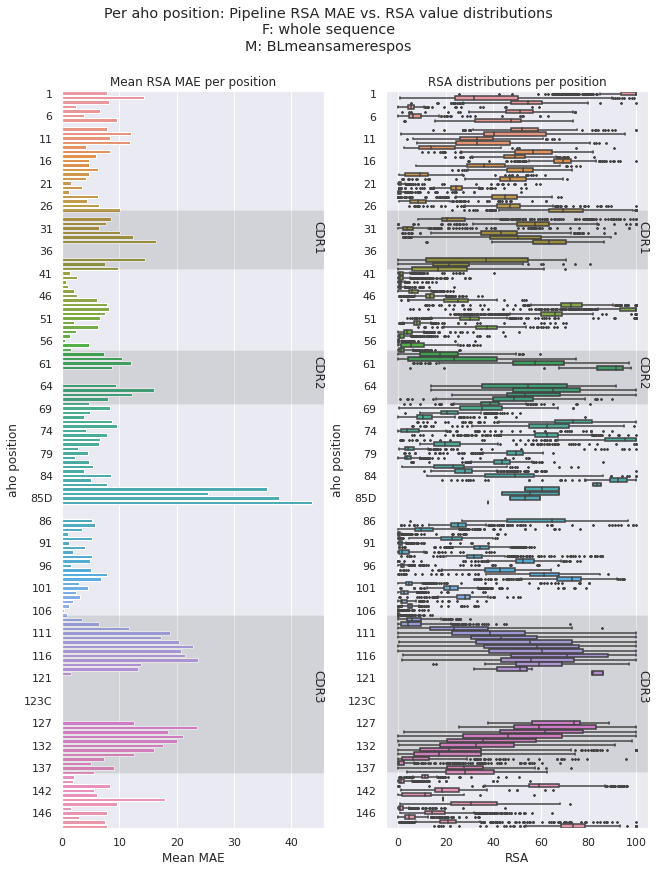

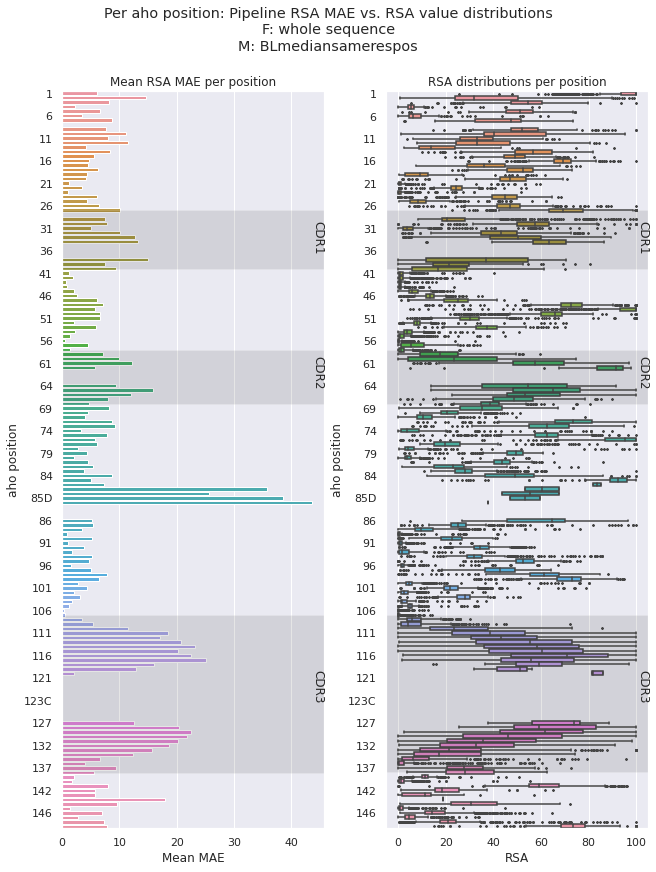

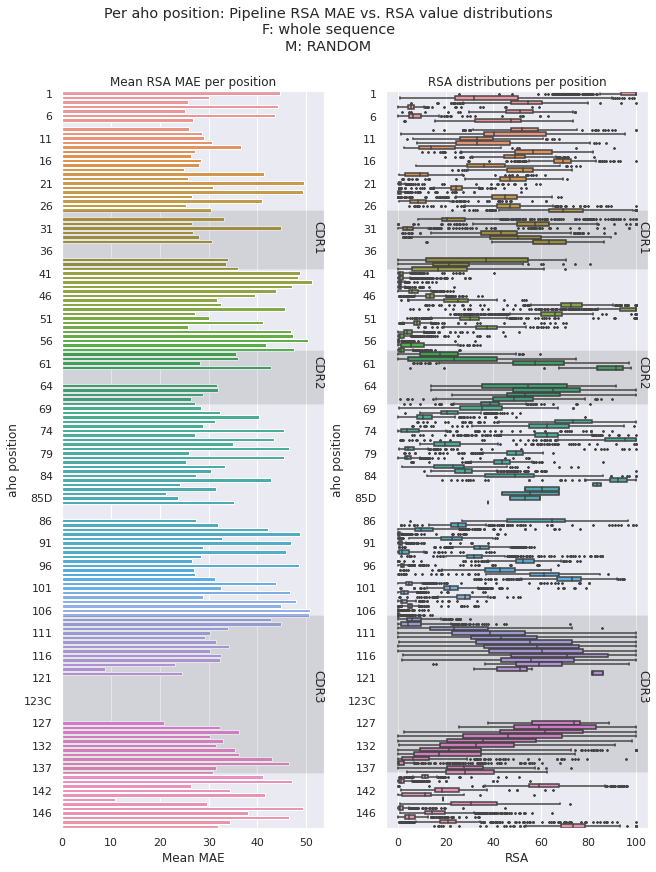

In [24]:
for scenario in tqdm(loss_per_position_df['scenario'].unique()):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, 
                                   figsize=(9, 12),
                                   constrained_layout=True)
    loss_df = loss_per_position_df[ loss_per_position_df['scenario'] == scenario ]
    ylabel = f'ANARCI position (scheme: {p.FINAL_NUMBERING_SCHEME})'
    fig.suptitle(f'Per {p.FINAL_NUMBERING_SCHEME} position: Pipeline RSA MAE vs. RSA value distributions\n{extract_from_scenario(scenario)}')
    
    # LEFT PLOT ------------------------------------------------------
    plot = sns.barplot(data=loss_df, 
                       y=loss_df['position'], 
                       x='abs_error',
                       ax=ax1, order=Y.columns)
    ax1.margins(y=0)
    _=u.annotate_plot(plot, x_rotation = 0, 
                      title='Mean RSA MAE per position', 
                      xlabel='Mean MAE', 
                      ylabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                      clean_ax_settings=dict(ax='y', nth_label_only=5))
    max_loss = loss_df['abs_error'].max()
    u.show_cdr_regions(list(Y.columns), ax1, CHAINS, 
                       p.FINAL_NUMBERING_SCHEME, max_loss, position_ax='y')
    
    # RIGHT PLOT ------------------------------------------------------
    plot2 =sns.boxplot(data=sasa_df, x='sasa', y='position', ax=ax2, order=Y.columns,
                       flierprops = dict(markerfacecolor = '0.50', markersize = 1))
    _=u.annotate_plot(plot2, x_rotation = 0, 
                      title='RSA distributions per position',
                      xlabel='RSA',
                      ylabel=f'{p.FINAL_NUMBERING_SCHEME} position', 
                      clean_ax_settings=dict(ax='y', nth_label_only=5))
    u.show_cdr_regions(list(Y.columns), ax2, CHAINS, 
                       p.FINAL_NUMBERING_SCHEME, cdr_label_coord=100, position_ax='y')
    fig.savefig(f'{TEST_PNG_DIR_PATH}/loss_position_{scenario}_boxplot_{EXPERIMENT_SETTINGS}.png')
    plt.show()


In [25]:
sns.set(rc={'figure.figsize':(12, 8)})

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/3656138315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


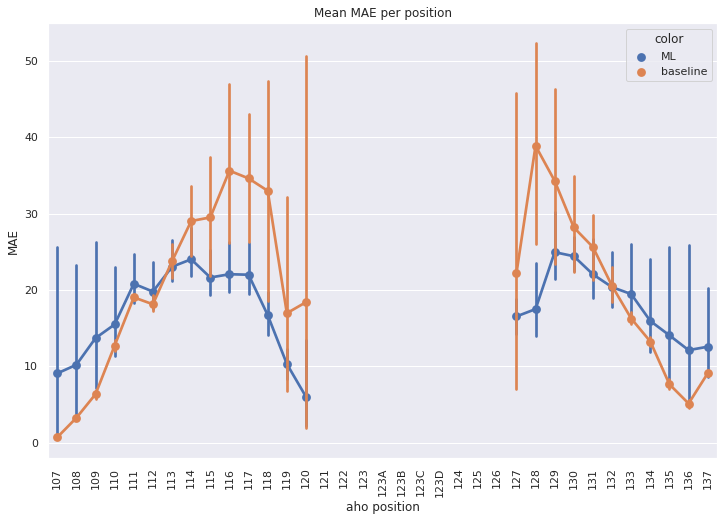

In [26]:
# line plot v cdr3, kazdy model ma svoju ciaru ako odchylku 
loss_per_position_df['scenario'].unique()
scenarios = ['lco_cont_window_r1_all_H_randomForestN30', 'lco_whole_sequence_all_H_BLavgpos'] 
#A 
#loss_per_position_df
start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[loss_per_position_df['position'].isin(cols)]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
plot = sns.pointplot(data=data, x='position', y='abs_error', hue='color')
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/3350718717.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


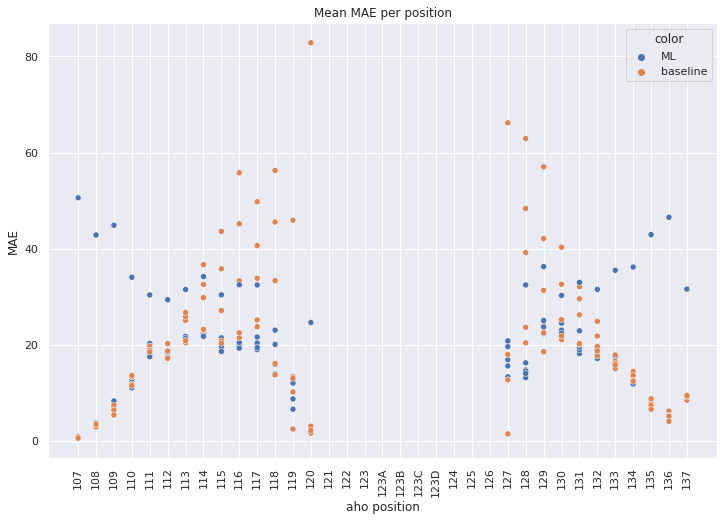

In [27]:
# line plot v cdr3, kazdy model ma svoju ciaru ako odchylku 
loss_per_position_df['scenario'].unique()
scenarios = ['lco_cont_window_r1_all_H_randomForestN30', 'lco_whole_sequence_all_H_BLavgpos'] 
#A 
#loss_per_position_df
start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[loss_per_position_df['position'].isin(cols)]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
plot = sns.scatterplot(data=data, x='position', y='abs_error', hue='color')
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/1951683485.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


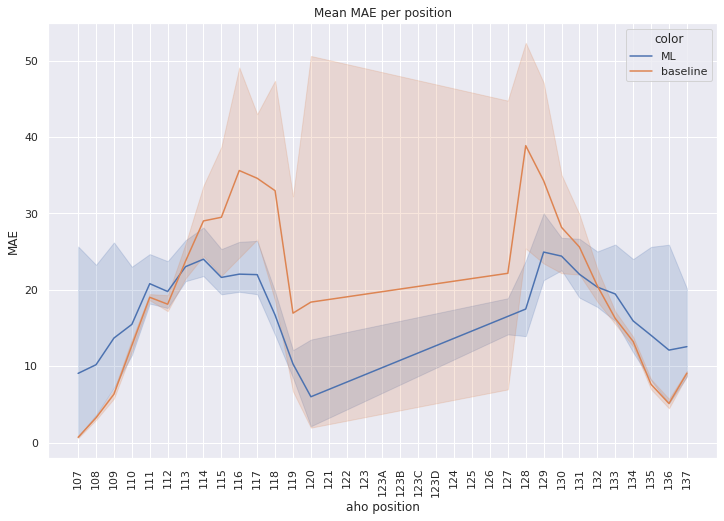

In [28]:
# line plot v cdr3, kazdy model ma svoju ciaru ako odchylku 
loss_per_position_df['scenario'].unique()
scenarios = ['lco_cont_window_r1_all_H_randomForestN30', 'lco_whole_sequence_all_H_BLavgpos'] 
#A 
#loss_per_position_df
start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[loss_per_position_df['position'].isin(cols)]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
plot = sns.lineplot(data=data, x='position', y='abs_error', hue='color')
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')

In [57]:
data['scenario'].unique()

array(['lco_cont_window_r4_all_H_randomForestN30',
       'lco_whole_sequence_all_H_BLmeansamerespos',
       'lco_whole_sequence_all_H_BLmediansamerespos'], dtype=object)

In [63]:
scenarios = list(loss_per_position_df['scenario'].unique())[:-1]
#scenarios = loss_per_position_df['scenario'].unique()
scenarios

['lco_cont_window_r1_all_H_randomForestN30',
 'lco_cont_window_r2_all_H_randomForestN30',
 'lco_cont_window_r3_all_H_randomForestN30',
 'lco_cont_window_r3_all_H_randomForestN5',
 'lco_cont_window_r4_all_H_randomForestN30',
 'lco_whole_sequence_all_H_BLavgpos',
 'lco_whole_sequence_all_H_BLknnwholeseqn10',
 'lco_whole_sequence_all_H_BLknnwholeseqn3',
 'lco_whole_sequence_all_H_BLmeansamerespos',
 'lco_whole_sequence_all_H_BLmediansamerespos']

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/2105518452.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


10


ValueError: '27' is not in list

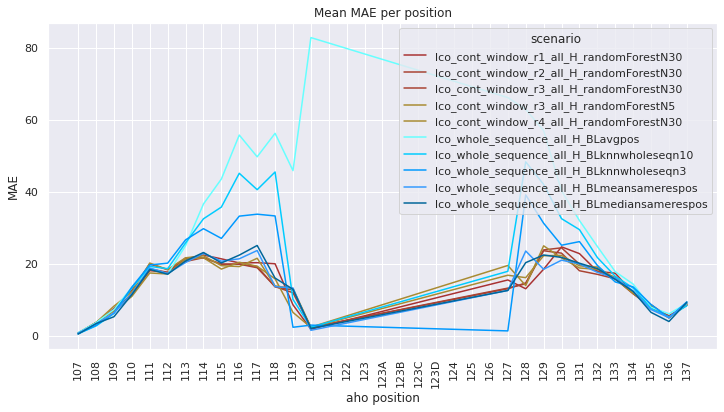

In [64]:
#scenarios = ['lco_cont_window_r1_all_H_randomForestN30',
#       'lco_cont_window_r2_all_H_randomForestN30',
#       'lco_cont_window_r3_all_H_randomForestN30',
#       'lco_cont_window_r3_all_H_randomForestN5',
#       'lco_cont_window_r4_all_H_randomForestN30',
#       'lco_whole_sequence_all_H_BLmediansamerespos']


start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[(loss_per_position_df['position'].isin(cols)) & (loss_per_position_df['scenario'].isin(scenarios))]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
print(data['scenario'].nunique())
plot = sns.lineplot(data=data, x='position', y='abs_error', hue='scenario',
                   palette=['#a83232', '#a84232', '#a84232', '#a88b32', '#a88b32', 
                            '#66FFFF', '#00CCFF', '#0099FF', '#3399FF', '#006699'])
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')
u.show_cdr_regions(cols, plot, CHAINS, 
                    p.FINAL_NUMBERING_SCHEME, cdr_label_coord=data['abs_error'].max(), 
                   position_ax='x', text_offsets = [3, 2, 14])
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/mae_per_position_all_line_{EXPERIMENT_SETTINGS}.png')

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/513993144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


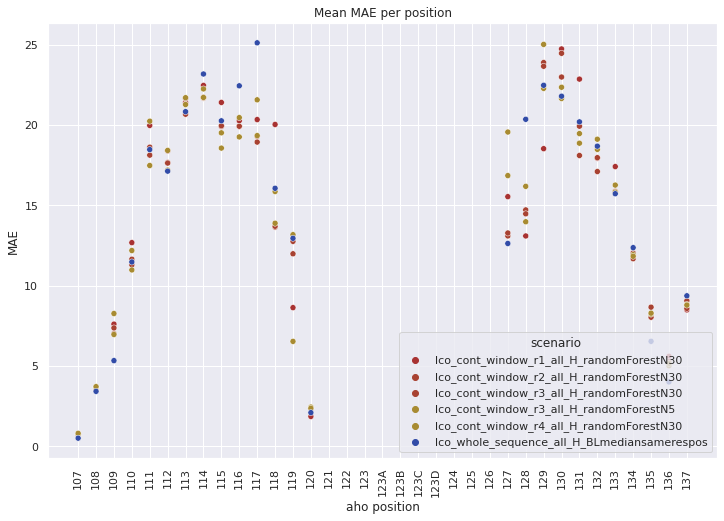

In [30]:
scenarios = ['lco_cont_window_r1_all_H_randomForestN30',
       'lco_cont_window_r2_all_H_randomForestN30',
       'lco_cont_window_r3_all_H_randomForestN30',
       'lco_cont_window_r3_all_H_randomForestN5',
       'lco_cont_window_r4_all_H_randomForestN30',
       'lco_whole_sequence_all_H_BLmediansamerespos']
start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[(loss_per_position_df['position'].isin(cols)) & (loss_per_position_df['scenario'].isin(scenarios))]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
plot = sns.scatterplot(data=data, x='position', y='abs_error', hue='scenario',
                   palette=['#a83232', '#a84232', '#a84232', '#a88b32', '#a88b32', 
                            '#324ca8'])
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')

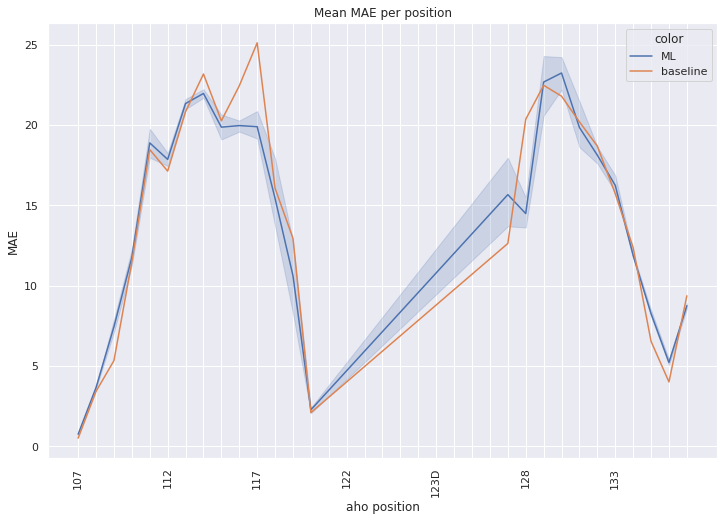

In [31]:
plot = sns.lineplot(data=data, x='position', y='abs_error', hue='color', sort=False)
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE',
                  clean_ax_settings=dict(ax='x', nth_label_only=5))

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/879151085.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'statistical' if 'BL' in s else 'ML')


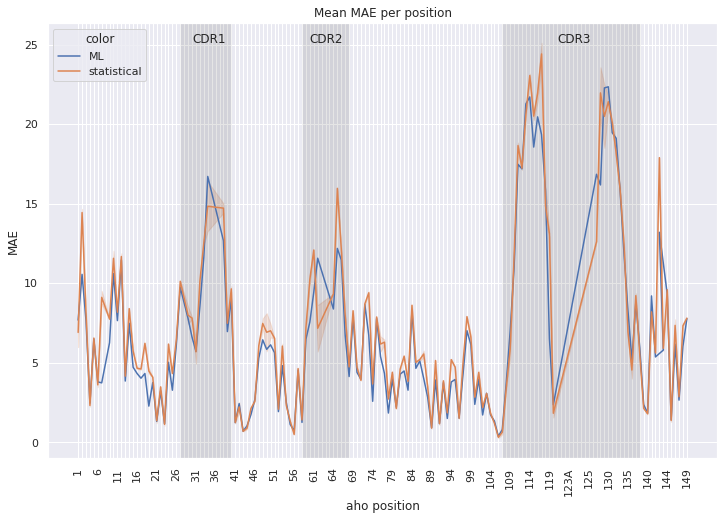

In [32]:
scenarios = [
       'lco_cont_window_r4_all_H_randomForestN30',
       'lco_whole_sequence_all_H_BLmeansamerespos',
       'lco_whole_sequence_all_H_BLmediansamerespos']
cols = list(Y.columns)
cols = [c for c in cols if not c.startswith('85') or len(c) <= 2]
data = loss_per_position_df[(loss_per_position_df['scenario'].isin(scenarios)) & (loss_per_position_df['position'].isin(cols))]
data['color'] = data['scenario'].apply(lambda s: 'statistical' if 'BL' in s else 'ML')
data = data.sort_values(by='position', key=lambda s: s.apply(u.anarci_column_sorter))
plot = sns.lineplot(data=data, x='position', y='abs_error', hue='color', sort=False)
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE',
                  clean_ax_settings=dict(ax='x', nth_label_only=5))
u.show_cdr_regions(cols, plot, CHAINS, 
                    p.FINAL_NUMBERING_SCHEME, cdr_label_coord=data['abs_error'].max(), 
                   position_ax='x', text_offsets = [3, 2, 14])
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/mae_per_position_MLbest_v_Sbest_line_{EXPERIMENT_SETTINGS}.png')

In [72]:
scenarios = loss_per_position_df['scenario'].unique()
scenarios = [
    'lco_whole_sequence_all_H_BLmediansamerespos',
    'lco_whole_sequence_all_H_BLavgpos',
    'lco_whole_sequence_all_H_BLknnwholeseqn3'
]   
scenarios

['lco_whole_sequence_all_H_BLmediansamerespos',
 'lco_whole_sequence_all_H_BLavgpos',
 'lco_whole_sequence_all_H_BLknnwholeseqn3']

3


/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/619084309.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'statistical' if 'BL' in s else 'ML')


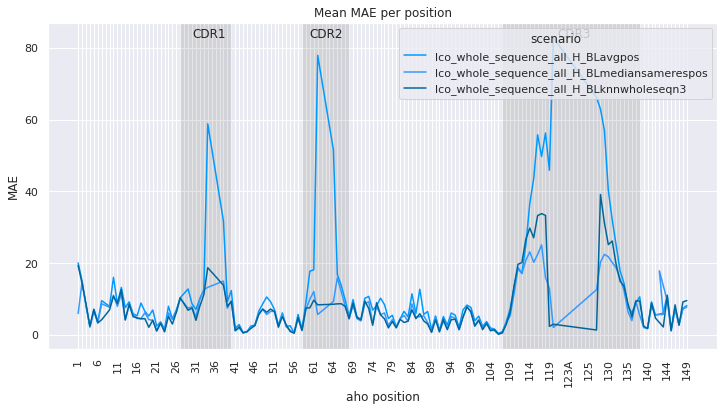

In [74]:
#scenarios = loss_per_position_df['scenario'].unique()
#scenarios = list(loss_per_position_df['scenario'].unique())[:-1]
print(len(scenarios))
cols = list(Y.columns)
cols = [c for c in cols if not c.startswith('85') or len(c) <= 2]
data = loss_per_position_df[(loss_per_position_df['scenario'].isin(scenarios)) & (loss_per_position_df['position'].isin(cols))]
data['color'] = data['scenario'].apply(lambda s: 'statistical' if 'BL' in s else 'ML')
data = data.sort_values(by='position', key=lambda s: s.apply(u.anarci_column_sorter))
plot = sns.lineplot(data=data, x='position', y='abs_error', hue='scenario', sort=False,
                   #palette=['#a83232', '#a84232', '#a84232', '#a88b32', '#a88b32', 
                   #         '#66FFFF', '#00CCFF', '#0099FF', '#3399FF', '#006699'])
                   palette=['#0099FF', '#3399FF', '#006699'])
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE',
                  clean_ax_settings=dict(ax='x', nth_label_only=5))
u.show_cdr_regions(cols, plot, CHAINS, 
                    p.FINAL_NUMBERING_SCHEME, cdr_label_coord=data['abs_error'].max(), 
                   position_ax='x', text_offsets = [3, 2, 14])
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/mae_per_position_all_line_{EXPERIMENT_SETTINGS}.png')

/var/tmp/pbs.1836808.ktchpcps002/ipykernel_31818/821279713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')


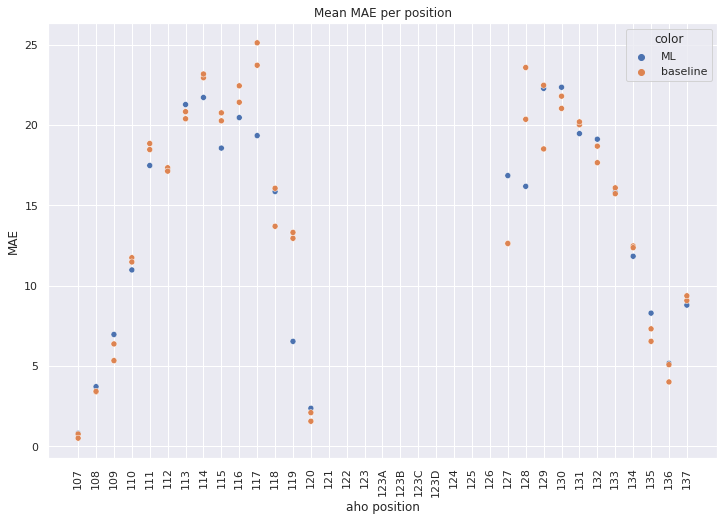

In [36]:
scenarios = [
       'lco_cont_window_r4_all_H_randomForestN30',
       'lco_whole_sequence_all_H_BLmeansamerespos',
       'lco_whole_sequence_all_H_BLmediansamerespos']
start, end = list(Y.columns).index('107'), list(Y.columns).index('138')
cols = list(Y.columns)[start:end]
data = loss_per_position_df[(loss_per_position_df['position'].isin(cols)) & (loss_per_position_df['scenario'].isin(scenarios))]
data['color'] = data['scenario'].apply(lambda s: 'baseline' if 'BL' in s else 'ML')
plot = sns.scatterplot(data=data, x='position', y='abs_error', hue='color')
_=u.annotate_plot(plot, x_rotation = 90, 
                  title=u.wrap(f'Mean MAE per position'), 
                  xlabel=f'{p.FINAL_NUMBERING_SCHEME} position',
                  ylabel='MAE')

---

**Do UMAP on 160D space (each position - one coordinate)**

---

**Generate summary deviations per ANARCI position:**

In [37]:
pos_df = results_df.groupby('position')['abs_error'].mean().to_frame()
pos_df = pos_df.sort_values(by='position', key=lambda s: s.apply(u.anarci_column_sorter))
pos_df.head(n=3)

,abs_error
position,
1,14.130085
2,14.124573
3,9.699147


**Show histogram of per-position-deviations:**

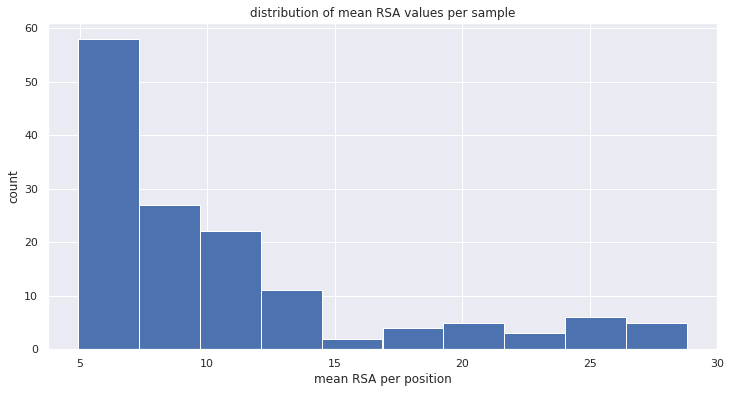

In [38]:
sns.set(rc={'figure.figsize':(12, 6)})
plot = pos_df.plot.hist(legend=False)
_=u.annotate_plot(plot, x_rotation = 0,
                  ylabel='count',
                  xlabel='mean RSA per position',
                  title='distribution of mean RSA values per sample')
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/loss_position_scenario_histogram_{EXPERIMENT_SETTINGS}.png')
                

**Which positions are generally hard to predict and which ones easy?**

In [39]:
HARD_TO_PREDICT_PERC_BOTTOM_THRESHOLD = 20
EASY_TO_PREDICT_PERC_TOP_THRESHOLD = 3

In [40]:
hard_positions = list(pos_df[pos_df['abs_error'] > HARD_TO_PREDICT_PERC_BOTTOM_THRESHOLD].index)
print(hard_positions)

['34', '85B', '85A', '85E', '85D', '85C', '113', '114', '115', '116', '117', '118', '127', '128', '129', '130', '131', '132']


In [41]:
easy_positions = list(pos_df[pos_df['abs_error'] < EASY_TO_PREDICT_PERC_TOP_THRESHOLD].index)
print(easy_positions)

[]


In [42]:
# vybrat par struktur
# naozaj maju chybu na tazkych poziciach?

---

## Catastrophic predictions

In [ ]:
start, end = list(Y.columns).index('107'), list(Y.columns).index('138'); cols = list(Y.columns)[start:end]
data_cdr3 = results_df[results_df['position'].isin(cols)].copy()
data_cdr3

In [ ]:
def get_df(data): 
    data['buried'] = data['sasa'] <= LOW
    data['exposed'] = data['sasa'] >= HIGH
    data['overpred'] = (data['buried'] == True) & (data['prediction'] >= HIGH)
    data['underpred'] = (data['exposed'] == True) & (data['prediction'] <= LOW)
    return pd.concat([        
        data.groupby('scenario')['underpred'].sum().to_frame(),
        data.groupby('scenario')['overpred'].sum().to_frame(),
    ], axis=1)

c_data, c_data_cdr3 = get_df(results_df), get_df(data_cdr3)
c_data_cdr3

In [ ]:
l = pd.merge(left_index=True, right_index=True, left=c_data, right=c_data_cdr3, suffixes=('_all', '_cdr3'))
l['underpred_cdr3_perc'] = l['underpred_cdr3'] / l['underpred_all'] * 100
l['overpred_cdr3_perc'] = l['overpred_cdr3'] / l['overpred_all'] * 100
l = l.reindex(columns = ['underpred_cdr3', 'underpred_all', 'underpred_cdr3_perc', 'overpred_cdr3', 'overpred_all', 'overpred_cdr3_perc'])
sns.scatterplot(data=l, x='underpred_cdr3_perc', y='overpred_cdr3_perc', hue='scenario', 
                palette=['#CC0000', '#FF0000', '#FF6633', '#FF9900', '#FFCC00', 
                            '#000099', '#0099CC', '#3399FF', '#66CCFF', '#33FFFF'], s=400)

In [ ]:
start, end = list(Y.columns).index('107'), list(Y.columns).index('138'); cols = list(Y.columns)[start:end]
#cols = Y.columns
data = results_df[results_df['position'].isin(cols)].copy()
print(cols)



In [ ]:
buried = data.groupby('scenario')['buried'].sum()
exposed = data.groupby('scenario')['exposed'].sum()
s = scenario_means.copy();  s.index = s['features'] + '_' + s['model']
s['buried'] = data.groupby('scenario')['buried'].sum()
s['overpredictions'] = data.groupby('scenario')['overpred'].sum()
s['overpredictions %'] = s['overpredictions'] / s['buried']
s['exposed'] = data.groupby('scenario')['exposed'].sum()
s['underpredictions'] = data.groupby('scenario')['underpred'].sum()
s['underpredictions %'] = s['underpredictions'] / s['exposed']
s.index = range(1, len(s) + 1)
s

In [ ]:
s2 = s.copy(); s2['pipeline'] = s2['features'] + '_' + s2['model']
plot = sns.scatterplot(data=s2, x='underpredictions %', y='overpredictions %', hue='pipeline', s=400,
               palette=['#CC0000', '#FF0000', '#FF6633', '#FF9900', '#FFCC00', 
                            '#000099', '#0099CC', '#3399FF', '#66CCFF', '#33FFFF'])
plot.set_title(f'Percentage of catastrophic predictions per pipeline')
plot.figure.savefig(f'{p.DATA_DIR}/png/test/catastrophes_per_scenario_scatter_{EXP_STRING}.png')

---

## 3D comparison

**Load the data:**

In [ ]:
data = pd.read_csv(f'{p.DATA_DIR}/csv/test/results_{EXPERIMENT_SETTINGS}.csv', index_col=0)
data['buried'] = data['sasa'] <= LOW
data['exposed'] = data['sasa'] >= HIGH
data['overpred'] = (data['buried'] == True) & (data['prediction'] >= HIGH)
data['underpred'] = (data['exposed'] == True) & (data['prediction'] <= LOW)
data.head(n=6)

In [ ]:
data['abs_error'].mean()

**Sequence we want to visualize should contain a lot of overpredictions
and underpredictions. Which one it is:**

In [ ]:
so = data.groupby(['sequence_id', 'scenario'])['overpred'].sum().to_frame()
su = data.groupby(['sequence_id', 'scenario'])['underpred'].sum().to_frame()
sosu = pd.merge(left=so, right=su, left_index=True, right_index=True)
sosu['all'] = sosu['overpred'] + sosu['underpred']
sosu = sosu.sort_values(by='all', ascending=False).reset_index()
sosu.head(n=1)

In [ ]:
! pip install py3Dmol

In [ ]:
COLOR_MAP = { 0: 'blue', 
              1: 'white', 
              2: 'pink', 
              3: 'red', 
              4: 'red'
}

In [ ]:
import io
import numpy as np
import pandas as pd
import py3Dmol

from Bio import PDB

def show_pdb(pdb, 
             show_sidechains = True, 
             color_map = COLOR_MAP):
    
    view = py3Dmol.view(width=800, height=600, js='https://cdnjs.cloudflare.com/ajax/libs/3Dmol/1.8.0/3Dmol.js')
    view.addModelsAsFrames(pdb)
    style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
    if show_sidechains:
        style['stick'] = {'colorscheme': {'prop': 'b', 'map': color_map}}
    view.addSurface(py3Dmol.SAS, {'opacity': 0.4, 'color': 'grey'})
    view.setStyle({'model': -1}, style)
    return view.zoomTo()

atom_types = [
    'N', 'CA', 'C', 'CB', 'O', 'CG', 'CG1', 'CG2', 'OG', 'OG1', 'SG', 'CD',
    'CD1', 'CD2', 'ND1', 'ND2', 'OD1', 'OD2', 'SD', 'CE', 'CE1', 'CE2', 'CE3',
    'NE', 'NE1', 'NE2', 'OE1', 'OE2', 'CH2', 'NH1', 'NH2', 'OH', 'CZ', 'CZ2',
    'CZ3', 'NZ', 'OXT'
]
atom_order = {atom_type: i for i, atom_type in enumerate(atom_types)}
atom_type_num = len(atom_types)  # := 37.

def overwrite_b_factors(pdb_str: str, chain_id: str, residue_data, vmin, vmax) -> str:
    """Overwrites the B-factors in pdb_str with contents of bfactors array.
    Args:
    pdb_str: An input PDB string.
    residue_data: A numpy array with shape [n_residues]
    vmin: Minimum value in residue_data used for normalization
    vmax: Maximum value in residue_data used for normalization
    Returns:
    A new PDB string with the B-factors replaced.
    """
    bands = ((np.clip(residue_data, vmin, vmax) - vmin) / vmax * 100) // 20
    bfactors = np.repeat(bands[:, np.newaxis], atom_type_num, axis=1)
    
    if bfactors.shape[-1] != atom_type_num:
        raise ValueError(f'Invalid final dimension size for bfactors: {bfactors.shape[-1]}.')

    parser = PDB.PDBParser(QUIET=True)
    handle = io.StringIO(pdb_str)
    structure = parser.get_structure('', handle)

    curr_resid = ('', '', '')
    idx = -1
    for atom in structure.get_atoms():
        #print(str(atom))
        if atom.get_full_id()[2] != chain_id:
            continue
        atom_resid = atom.parent.get_id()
        if atom_resid != curr_resid:
            idx += 1
            if idx >= bfactors.shape[0]:
                raise ValueError(f'Index into bfactors exceeds number of residues. B-factors shape: {bfactors.shape}, idx: {idx}.')
        curr_resid = atom_resid
        atom.bfactor = bfactors[idx, atom_order['CA']]

    new_pdb = io.StringIO()
    pdb_io = PDB.PDBIO()
    pdb_io.set_structure(structure)
    pdb_io.save(new_pdb)
    return new_pdb.getvalue()

In [ ]:
SEQUENCE_ID = '7N8I:H'
s = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_aligned/sasa_{SEQUENCE_ID[-1]}.csv', index_col=0)
with open(f'{p.DATA_DIR}/pdb/incremental/{SEQUENCE_ID[:4].lower()}.pdb') as f: pdb_raw = f.read()

In [ ]:
s

In [ ]:
def cdrnumber(i):
    ii = int(i[:-1]) if not i[-1].isnumeric() else int(i)
    if 27 <= ii <= 40:
        return 20
    elif 58 <= ii <= 68:
        return 40
    elif 107 <= ii <= 138:
        return 60
    return 0
color_map = {
    0: 'white',
    1: 'red',
    2: 'blue',
    3: 'green'
}
sasa_default = s.loc[SEQUENCE_ID].transpose().dropna().to_frame()
sasa_default['index'] = sasa_default.index
sasa_default['cdr'] = sasa_default['index'].apply(cdrnumber)
#sasa_default.index = range(1, len(sasa_default)+1)
sasa_default.drop(columns=['index', '7N8I:H'], inplace=True)
sasa_default.columns = ['7N8I:H']
#list(sasa_default['cdr'])
sasa_default = sasa_default['7N8I:H']
#sasa_default['index'].map(cdrnumber).sum()
sasa_default

In [ ]:
color_map = { 0: 'blue', 
              1: 'white', 
              2: 'pink', 
              3: 'red', 
              4: 'red'
}
sasa_default = s.loc[SEQUENCE_ID].transpose().dropna(); #sasa_default.index = range(1, len(sasa_default) + 1); 
sasa_default

In [ ]:
pdb_sasa_default = overwrite_b_factors(pdb_raw, SEQUENCE_ID[-1], sasa_default, vmin=0, vmax=100)
pdb_sasa_default = '\n'.join([line for line in pdb_sasa_default.split('\n') if len(line) < 22 or line[21] == 'H'])
view = show_pdb(pdb_sasa_default, color_map=color_map)
view.zoom(1); view.rotate(-40)

In [ ]:
sasa_default

In [ ]:
sasa_predicted = data[ (data['scenario'] == 'lco_cont_window_r4_all_H_randomForestN30') & (data['sequence_id'] == SEQUENCE_ID) ][['position', 'prediction']].drop(columns='position').dropna()
sasa_predicted.index = range(1, len(sasa_predicted) + 1)
sasa_predicted = sasa_predicted['prediction']
pdb_sasa_predicted = overwrite_b_factors(pdb_raw, SEQUENCE_ID[-1], sasa_predicted, vmin=0, vmax=100)
pdb_sasa_predicted = '\n'.join([line for line in pdb_sasa_predicted.split('\n') if len(line) < 22 or line[21] == 'H'])
view = show_pdb(pdb_sasa_predicted)
view.zoom(1); view.rotate(-40)

In [ ]:
data[ (data['scenario'] == 'lco_cont_window_r4_all_H_randomForestN30') & (data['sequence_id'] == SEQUENCE_ID) ]['underpred'].sum()

In [ ]:
CHAIN_ID = '7N8I:H'
#s = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_relative_unaligned/sasa_all.csv', index_col=0)
s = pd.read_csv(f'{p.DATA_DIR}/csv/sasa_aligned/sasa_H.csv', index_col=0)
with open(f'{p.DATA_DIR}/pdb/incremental/{CHAIN_ID[:4].lower()}.pdb') as f: pdb_raw = f.read()
sasa_default = s.loc[CHAIN_ID].transpose().dropna(); sasa_default.index = range(1, len(sasa_default) + 1); sasa_default
pdb_sasa_default = overwrite_b_factors(pdb_raw, CHAIN_ID, sasa_default, vmin=0, vmax=1)
show_pdb(pdb_sasa_default)

---

In [ ]:
cata_per_pos_df = results_df.groupby('position').agg({'overpred': 'sum', 'underpred': 'sum'})
plot = cata_per_pos_df.plot.scatter(x='underpred', y='overpred')
_=u.annotate_plot(plot, x_rotation = 0, 
                      title=u.wrap(f'overpredictions vs. underpredictions, per position, summed for all scenarios {EXP_STRING}', n=60), 
                      xlabel=u.wrap('# of overpredictions in one ANARCI position, summed for all scenarios', n=40), 
                      ylabel=u.wrap('# of underpredictions in one ANARCI position, summed for all scenarios', n=40), 
                      )
plot.figure.savefig(f'{TEST_PNG_DIR_PATH}/catastrophes_by_position_{ALPHA}_{BETA}_scatter_{EXPERIMENT_SETTINGS}.png')

In [ ]:
cata_per_pos_df

NameError: name 'cata_per_pos_df' is not defined

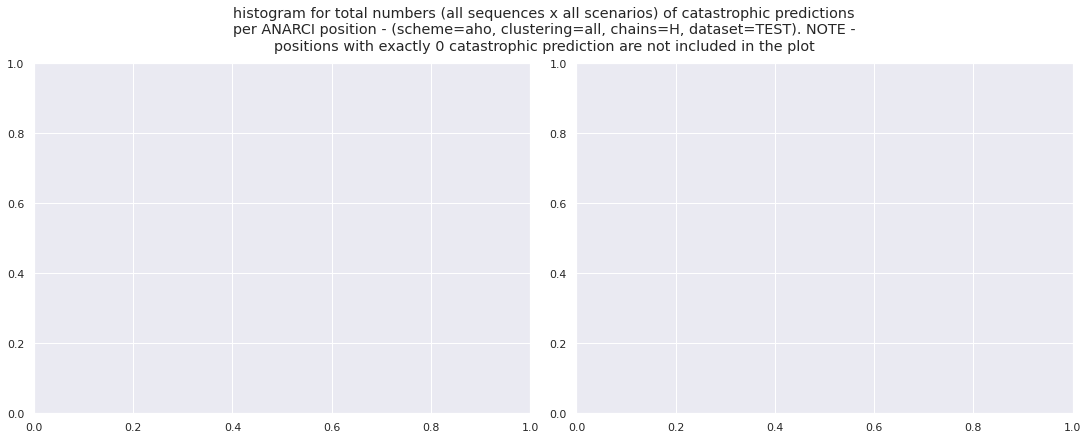

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15, 6),
                               constrained_layout=True)
fig.suptitle(u.wrap(f'histogram for total numbers (all sequences x all scenarios) of catastrophic predictions per ANARCI position - {EXP_STRING}. NOTE - positions with exactly 0 catastrophic prediction are not included in the plot ', 90))
cata_per_pos_df[ cata_per_pos_df['overpred'] > 1]['overpred'].plot.hist(bins=30, ax=ax1)
cata_per_pos_df[ cata_per_pos_df['underpred'] > 1]['underpred'].plot.hist(bins=30, ax=ax2)
_=u.annotate_plot(ax1, xlabel=u.wrap(f'overpredictions (realRSA <= {ALPHA}, predictedRSA >= {BETA}) count per ANARCI position (total summed)', 60))
_=u.annotate_plot(ax2, xlabel=u.wrap(f'underpredictions (realRSA >= {BETA}, predictedRSA <= {ALPHA}) count per ANARCI position (total summed)', 60))
fig.savefig(f'{TEST_PNG_DIR_PATH}/catastrophes_by_position_{ALPHA}_{BETA}_hist_{EXPERIMENT_SETTINGS}')

In [ ]:
results_df.groupby('position')['overpred'].sum() / results_df.groupby('position')['sequence_id'].count()

---

## Code dump

In [ ]:
#Y.std().sort_values().tail(50)

In [ ]:
#Y_melted.head(n=1)

In [ ]:
# jake konkretni pozice jsou lehke na predikci a jake tezke? 
# (zamer se na pozice, ktere se vyskytuji casto - ne ty na kterych jsou vetsinou gapy)

position_df = total_scenario_df.groupby('Id')['score'].mean().to_frame()
position_df.index = sorted(position_df.index, key=u.anarci_column_sorter)
position_df['count'] = Y_melted[ Y_melted['value'] != -1 ]['variable'].value_counts()

In [ ]:
print('before count filer shape:', position_df.shape)
COUNT_PERCENTUAL_THRESHOLD = 50
THRESHOLD = position_df['count'].max() * COUNT_PERCENTUAL_THRESHOLD = 50 / 100
position_df = position_df[ position_df['count'] >= position_df['count'].max() * COUNT_PERCENTUAL_THRESHOLD / 100]
print(f'after count filter (perc={COUNT_PERCENTUAL_THRESHOLD}) shape: {position_df.shape}')
position_df.head(n=3)

# vybrat par struktur
# naozaj maju chybu na tazkych poziciach?

In [ ]:
ax = sns.scatterplot(
    x=Y.replace(-1, np.nan).std().reindex(position_df.index),
    y=position_df['score'],
)    
ax.set_xlim(0, 61)
ax.set_ylim(0, 61)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 15))
plot = sns.barplot(data=position_df, y=position_df.index, x='score')
_=u.annotate_plot(plot, x_rotation = 0, 
                  title='Mean % absolute deviation per ANARCI position (ALL models, dataset: TEST)', 
                  xlabel='mean % absolute deviation', 
                  ylabel=f'ANARCI position (scheme: {p.FINAL_NUMBERING_SCHEME})', 
                  clean_ax_settings=dict(ax='y', nth_label_only=5))

In [ ]:
position_df['score'].plot.hist()

## Catastrophic predictions

## Per sample

In [ ]:
MODEL_NAME = 'BLavgpos'
FEATURES = 'lco_whole_sequence_all_H'
TEST_Y_RAW_PATH = f'{p.DATA_DIR}/csv/test/raw_y/{FEATURES}_{MODEL_NAME}.csv'
TEST_Y_PREDS_PATH = f'{p.DATA_DIR}/csv/test/raw_predictions/{FEATURES}_{MODEL_NAME}.csv'
TEST_STATS_BY_SAMPLE_PATH = f'{p.DATA_DIR}/csv/test/scores_per_sample/{FEATURES}_{MODEL_NAME}.csv'

Y = pd.read_csv(TEST_Y_RAW_PATH, index_col=0)
preds = pd.read_csv(TEST_Y_PREDS_PATH, index_col=0)
by_sample = pd.read_csv(TEST_STATS_BY_SAMPLE_PATH, index_col=0)

# >=50 predicted <=10 reality (overpredict)
# <=10 predicted >=50 reality (underpredict)

def count_catastrophes(row):
    P = preds
    unds, ovs = 0, 0
    for col in Y.columns:
        if Y.loc[row.name, col] >= 50 and P.loc[row.name, col] <= 10:
            unds += 1
        if Y.loc[row.name, col] <= 10 and P.loc[row.name, col] >= 50:
            ovs += 1
    return unds, ovs
        
cc = Y.apply(count_catastrophes, axis=1)
unders, overs = [c[0] for c in cc], [c[1] for c in cc]
by_sample['underpreds'] = unders
by_sample['overpreds'] = overs
by_sample['misspreds'] = by_sample['underpreds'] + by_sample['overpreds']
by_sample.to_csv(TEST_STATS_BY_SAMPLE_PATH)


In [ ]:
by_sample = pd.read_csv(TEST_STATS_BY_SAMPLE_PATH, index_col=0)
by_sample

### Per ANARCI position

In [ ]:
MODEL_NAME = 'BLavgpos'
FEATURES = 'lco_whole_sequence_all_H'
TEST_Y_RAW_PATH = f'{p.DATA_DIR}/csv/test/raw_y/{FEATURES}_{MODEL_NAME}.csv'
TEST_Y_PREDS_PATH = f'{p.DATA_DIR}/csv/test/raw_predictions/{FEATURES}_{MODEL_NAME}.csv'
TEST_STATS_BY_SAMPLE_PATH = f'{p.DATA_DIR}/csv/test/scores_per_position/{FEATURES}_{MODEL_NAME}.csv'

Y = pd.read_csv(TEST_Y_RAW_PATH, index_col=0)
preds = pd.read_csv(TEST_Y_PREDS_PATH, index_col=0)
by_pos = pd.read_csv(TEST_STATS_BY_SAMPLE_PATH, index_col=0)

# >=50 predicted <=10 reality (overpredict)
# <=10 predicted >=50 reality (underpredict)

def count_catastrophes(col):
    P = preds
    unds, ovs = 0, 0
    for row in Y.index:
        if Y.loc[row, col.name] >= 50 and P.loc[row, col.name] <= 10:
            unds += 1
        if Y.loc[row, col.name] <= 10 and P.loc[row, col.name] >= 50:
            ovs += 1
    return unds, ovs
        
cc = Y.apply(count_catastrophes, axis=0).transpose().reset_index(drop=True)
by_pos['underpreds'] = cc[0]
by_pos['overpreds'] = cc[1]
by_pos.head(n=3)




copied from 03b: remove later

---

In [ ]:
TEST_SCORES_TOTAL_DIR_PATH = f'{p.DATA_DIR}/csv/test/scores'
command = f'mkdir -p {TEST_SCORES_TOTAL_DIR_PATH}'
! $command

In [ ]:
TEST_SCORES_PER_SAMPLE_DIR_PATH = f'{p.DATA_DIR}/csv/test/scores_per_sample'
command = f'mkdir -p {TEST_SCORES_PER_SAMPLE_DIR_PATH}'
! $command

In [ ]:
TEST_SCORES_PER_POSITION_DIR_PATH = f'{p.DATA_DIR}/csv/test/scores_per_position'
command = f'mkdir -p {TEST_SCORES_PER_POSITION_DIR_PATH}'
! $command

## Total score

In [ ]:
score = u.avg_deviation(Y, predictions)
score

In [ ]:
with open(f'{TEST_SCORES_TOTAL_DIR_PATH}/{FEATURES}_{MODEL_NAME}.csv', 'w') as final_score_file:
    final_score_file.write(str(score))

---